In [1]:
import glob

from fastai.text import *
# from fastai.callbacks import SaveModelCallback
import sentencepiece as spm #https://github.com/google/sentencepiece

from prod.sp_tok import *

#torch.backends.cudnn.enabled=False #for quant.313v machine.  Not sure why...

In [2]:
PATH = Path('./data/rnn')
sp_model = './all_tweets_es_0609'

defaults.text_spec_tok.append(NL) #add a New Line special char
sp_vocab = Vocab( get_itos(sp_model) )
mycust_tok = CustomTokenizer(SPTokenizer,sp_model,pre_rules=default_rules)

In [3]:
test_df = pd.read_csv('./data/haha_2019_test.csv')
test_df['is_humor'] = 0
test_df['is_humor'].iloc[0] = 1 #create two classes in data.
## apply the rules
raw_text = test_df.loc[:,'text']

print("Default Rules:\n",[x.__name__ for x in default_rules],"\n\n")
for rule in default_rules:
    raw_text = raw_text.apply(lambda x: rule(str(x)))    
test_df['new_text'] =  raw_text #tokenizer adds xxbos

data_tst = TextClasDataBunch.from_df(PATH, test_df, test_df,
                               tokenizer=mycust_tok, vocab=sp_vocab,
                               text_cols='new_text', label_cols='is_humor')

In [4]:
model_wt_fnames = [x.split('/')[-1] for x in glob.glob( str(PATH/'models')+'/haha_clas_0610_mix_fld*.pth')]
len(model_wt_fnames), model_wt_fnames[:5]

(6,
 ['haha_clas_0610_mix_fld1_432286.pth',
  'haha_clas_0610_mix_fld2_432286.pth',
  'haha_clas_0610_mix_fld0_432286.pth',
  'haha_clas_0610_mix_fld4_432286.pth',
  'haha_clas_0610_mix_fld0_925619.pth'])

In [5]:
!grep Clas ./prod/out_fwd_tmp200.txt > ./by_seed_fwd_perf

In [6]:
## be more picky about the models.  Take the top quarter in validation. Does better val -> better test?
valid_perf = pd.read_csv('by_seed_fwd_perf', names = ['id','acc','F1'])
valid_perf['rnd_seed'] = valid_perf.id.str.split(':',expand=True).iloc[:,-1].str.strip()
valid_perf['nfold'] = valid_perf.id.str.split(' ',expand=True).iloc[:,2]
valid_perf.head()

,id,acc,F1,rnd_seed,nfold
0,Clas Fold: 0 RndSeed: 432286,0.860625,0.816985,432286,0
1,Clas Fold: 1 RndSeed: 432286,0.870000,0.828288,432286,1
2,Clas Fold: 2 RndSeed: 432286,0.869583,0.829965,432286,2
3,Clas Fold: 3 RndSeed: 432286,0.854583,0.808533,432286,3
4,Clas Fold: 4 RndSeed: 432286,0.866875,0.825648,432286,4


Text(0.5, 1.0, 'Freq of F1 over all Random Seeds (200) \n Vert line = 75th p-tile')

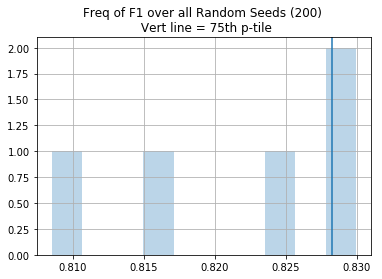

In [7]:
valid_perf.F1.hist(alpha=0.3)
#valid_perf.groupby('rnd_seed')['F1'].mean().hist(alpha=0.3)
plt.axvline(x=valid_perf.F1.quantile(0.75))
#valid_perf[valid_perf.F1 >= valid_perf.F1.quantile(0.75)].F1.hist(alpha=0.3)
plt.title('Freq of F1 over all Random Seeds (200) \n Vert line = 75th p-tile')

In [8]:
seed_grouped_F1 = valid_perf.groupby('rnd_seed')['F1'].mean()
selected_seeds = seed_grouped_F1[seed_grouped_F1>=seed_grouped_F1.quantile(0.)].index.values.tolist()
seed_fold_pair = valid_perf[valid_perf.rnd_seed.isin(selected_seeds)].loc[:,['rnd_seed','nfold']].values
model_wt_fnames = []
for (seed,fold) in seed_fold_pair:
    model_wt_fnames.append(f'haha_clas_0610_mix_fld{fold}_{seed}.pth')
model_wt_fnames

['haha_clas_0610_mix_fld0_432286.pth',
 'haha_clas_0610_mix_fld1_432286.pth',
 'haha_clas_0610_mix_fld2_432286.pth',
 'haha_clas_0610_mix_fld3_432286.pth',
 'haha_clas_0610_mix_fld4_432286.pth']

In [9]:
ensemble_preds = []
for wt_fname in model_wt_fnames:
    config = awd_lstm_clas_config.copy()
    config['qrnn'] = True
    config['n_hid'] = 2304
    
    learn = text_classifier_learner(data_tst, AWD_LSTM, drop_mult=0.7,pretrained=False,
                               config=config)
    learn = learn.load(wt_fname.split('.')[0]) #load weights
    preds_t,y_t,losses_t = learn.get_preds(DatasetType.Valid,with_loss=True, ordered=True)
    ensemble_preds.append(to_np(preds_t))

In [10]:
np.array(ensemble_preds).shape

(5, 6000, 2)

In [11]:
np.array(ensemble_preds)

array([[[0.391247, 0.608753],
        [0.914857, 0.085143],
        [0.068503, 0.931497],
        [0.799872, 0.200128],
        ...,
        [0.739926, 0.260074],
        [0.762643, 0.237357],
        [0.602736, 0.397264],
        [0.368827, 0.631173]],

       [[0.336722, 0.663278],
        [0.82959 , 0.17041 ],
        [0.034502, 0.965498],
        [0.922451, 0.077549],
        ...,
        [0.540781, 0.459219],
        [0.906301, 0.093699],
        [0.161951, 0.838048],
        [0.144647, 0.855353]],

       [[0.286913, 0.713087],
        [0.775852, 0.224148],
        [0.113242, 0.886757],
        [0.920689, 0.079311],
        ...,
        [0.861725, 0.138275],
        [0.882924, 0.117076],
        [0.429345, 0.570655],
        [0.171019, 0.828981]],

       [[0.388849, 0.611151],
        [0.905228, 0.094772],
        [0.095343, 0.904657],
        [0.929374, 0.070626],
        ...,
        [0.712123, 0.287877],
        [0.807172, 0.192827],
        [0.368729, 0.631271],
        [0.2

In [12]:
ens_mean = np.array(ensemble_preds).mean(axis=0)
ens_mean

array([[0.356112, 0.643888],
       [0.856946, 0.143054],
       [0.074951, 0.925049],
       [0.910772, 0.089228],
       ...,
       [0.742021, 0.257979],
       [0.848362, 0.151638],
       [0.423416, 0.576584],
       [0.231649, 0.768351]], dtype=float32)

In [13]:
out_df = test_df['id'].to_frame().copy()
out_df['is_humor'] = ens_mean.argmax(axis=1)
out_df['funniness_average'] = 3.

In [14]:
out_df.head()

,id,is_humor,funniness_average
0,tweet1,1,3.0
1,tweet2,0,3.0
2,tweet3,1,3.0
3,tweet4,0,3.0
4,tweet5,0,3.0


In [15]:
out_df.to_csv('sub0610_mixup.csv',header=True,index=False)